# Load packages

In [195]:
import requests
import pandas as pd
import seaborn as sns
import chardet
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns 

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
         "#020887", # Phthalo Blue

         "#7DCD85", # Emerald

        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)
    return hex_color_list
    
pal=make_aesthetic()



# Read in data

I downloaded a claned file from this github repo:

`https://github.com/CenterForOpenScience/rpp/blob/master/data_allformats/RPPdataConverted.csv`

I downloaded this 2024-03-23. 

In [184]:
with open('RPPdataConverted.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# It has weird encoding so 
# use chardet to find encoding
# and read in lines that don't error out
encoding = result['encoding'] 
print("Encoding", encoding)
df = pd.read_csv('RPPdataConverted.csv', encoding=encoding, on_bad_lines='skip')

print(sorted(df.columns))

Encoding Windows-1252
['1st.author.O', '1st.author.R', '80.power', '90.power', '95.power', 'Actual.Power.O', 'Analysis.completion.date.R', 'Area.of.expertise.R', 'Authors.O', 'Calculated.P.value.O', 'Citation.Count.1st.author.O', 'Citation.count.1st.author.R', 'Citation.count.paper.O', 'Citation.count.senior.author.O', 'Citation.count.senior.author.R', 'Citations.R', 'Coder.s.email.R', 'Collect.materials.from.authors', 'Completion.R', 'Contact.Researcher.R', 'Current.position.R', 'Data.collection.quality.R', 'Degree.R', 'Description.of.effect.O', 'Descriptors.O', 'Differences.R', 'Difficulty.of.implimentation.R', 'Direction.R', 'Discipline.O', 'Domain.expertise.R', 'Dummy', 'Effect.Size.R', 'Effect.similarity.R', 'Effect.size.O', 'Exciting.result.O', 'Feasibility.O', 'Findings.similarity.R', 'Implementation.quality.R', 'Institution.1st.author.O', 'Institution.1st.author.R', 'Institution.prestige.1st.author.O', 'Institution.prestige.1st.author.R', 'Institution.prestige.senior.author.O',

# Data Wrangling

## Dates

In [186]:
df['rep_date'] = pd.to_datetime(df['Analysis.completion.date.R'], format='mixed')
df['orig_date'] = pd.to_datetime(df['Study.claim.date.R'], format='mixed')
df['time_since'] = (df['rep_date'] - df['orig_date']).dt.days
df['time_since_yr'] = df['time_since']/365

In [187]:
df[['rep_date', 'orig_date', 'time_since']].head(5)

,rep_date,orig_date,time_since
0,2015-01-07,2014-07-25,166.0
1,2014-11-18,2013-12-01,352.0
2,2015-05-21,2014-08-02,292.0
3,2015-01-01,2014-07-11,174.0
4,2015-01-08,2012-06-22,930.0


## Effects

See line 191 of their analysis code 

(https://github.com/CenterForOpenScience/rpp/blob/master/masterscript.R). 

I similariy use `T_r.O` and `T_r.R`

# Analysis

In [188]:
df['diff'] = df['T.r.O'] - df['T.r.R']
df2 = df.dropna(subset=['diff', 'time_since'])

print("Spearman r original and replicated:", np.round(stats.spearmanr(df2['T.r.O'],df2['T.r.R']).statistic,2))
print("Spearman r diff and time:", np.round(stats.spearmanr(df2['diff'],df2['time_since']).statistic,3))

Spearman r original and replicated: 0.48
Spearman r diff and time: 0.003


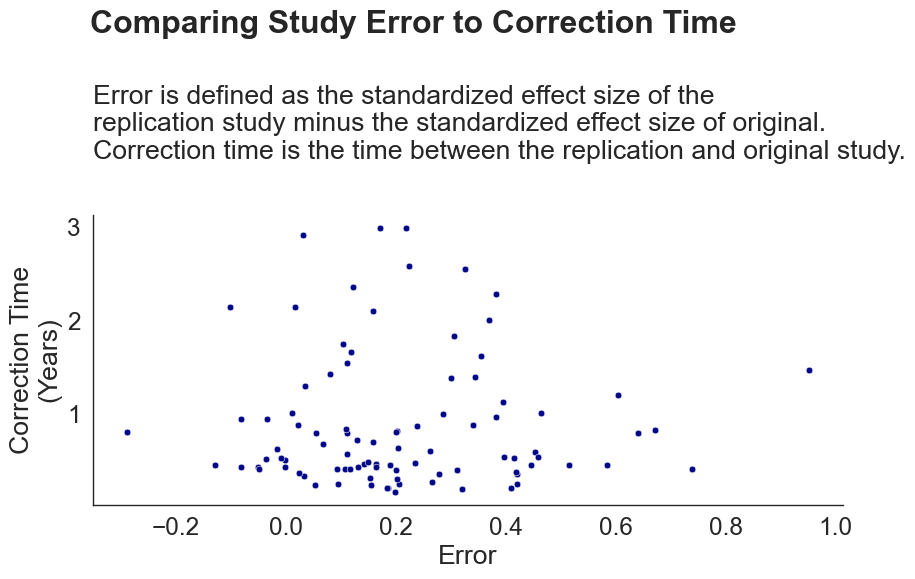

In [204]:
plt.figure(figsize=(9,6))
sns.scatterplot(data=df2, y='time_since_yr', x='diff')
plt.xlabel("Error")
plt.ylabel("Correction Time\n(Years)")
plt.suptitle("Comparing Study Error to Correction Time", fontweight='bold', x=0.48)
plt.title("Error is defined as the standardized effect size of the\nreplication study minus the standardized effect size of original.\nCorrection time is the time between the replication and original study.")
plt.savefig("science.pdf", format='pdf', dpi=300, bbox_inches='tight')